### **Import Libraries**

In [16]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


In [17]:
# Extract ZIP Dataset
zip_path = "MobiFall_Dataset.zip"
extract_path = "MobiFall_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted!")
print(os.listdir(extract_path))

Dataset extracted!
['MobiFall_Dataset_v2.0']


### **Dataset Paths & Classes**

In [18]:
# Dataset Paths & Classes
root_path = os.path.join(extract_path, "MobiFall_Dataset_v2.0", "sub10")

activities = {
    "STD": "Standing",
    "SCH": "Sitting",
    "WAL": "Walking",
    "BSC": "Back_Sitting_Chair",
    "FOL": "Fall_Forward_Lying",
    "SDL": "Sideward_Lying"
}

parent_map = {
    "ADL": ["STD", "SCH", "WAL"],
    "FALLS": ["BSC", "FOL", "SDL"]
}

print("sub10 folders:", os.listdir(root_path))


sub10 folders: ['FALLS', 'ADL']


### **Dataset Loading**

In [19]:
# Load & Parse .txt Files
data_list = []

for parent, subs in parent_map.items():
    for sub in subs:
        folder = os.path.join(root_path, parent, sub)
        for file in os.listdir(folder):
            if file.endswith(".txt"):
                file_path = os.path.join(folder, file)

                # Skip headers, read only data after @DATA
                with open(file_path, 'r') as f:
                    lines = f.readlines()
                    start_idx = lines.index("@DATA\n") + 1

                df = pd.read_csv(
                    file_path,
                    skiprows=start_idx,
                    header=None
                )

                df.columns = ["timestamp", "accX", "accY", "accZ"]
                df["label"] = activities[sub]

                data_list.append(df)

data = pd.concat(data_list, ignore_index=True)

print("Data shape:", data.shape)
print("Classes:", data["label"].unique())
print("\nLabels Distribution:\n", data['label'].value_counts())
data.head()


Data shape: (355313, 5)
Classes: ['Standing' 'Sitting' 'Walking' 'Back_Sitting_Chair' 'Fall_Forward_Lying'
 'Sideward_Lying']

Labels Distribution:
 label
Walking               148408
Standing              145934
Sitting                17466
Sideward_Lying         14538
Back_Sitting_Chair     14521
Fall_Forward_Lying     14446
Name: count, dtype: int64


,timestamp,accX,accY,accZ,label
0,1662273718000,0.026878,-0.075747,0.097433,Standing
1,1662278721000,0.026878,-2.197893,0.003054,Standing
2,1662283698000,3.810272,0.745256,0.030238,Standing
3,1662288824000,-1.171945,0.749837,0.031765,Standing
4,1662293666000,-1.173778,0.744034,0.032376,Standing


### **Preprocessing**

In [20]:
# Preprocessing
# Convert timestamp to datetime
data["timestamp"] = pd.to_datetime(data["timestamp"], unit='ns')

# Sort by time
data = data.sort_values("timestamp")

# Missing values
print("Missing values:", data.isnull().sum().sum())
data = data.ffill()

# Remove duplicates
data = data.drop_duplicates()

# Count duplicate rows
duplicate_rows = data.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

print("Final shape after preprocessing:", data.shape)


Missing values: 0
Number of duplicate rows: 0
Final shape after preprocessing: (355313, 5)


### **Sequence Preparation (Windowing)**

In [30]:
# 3. Sequence Preparation (Windowing)
# Reshaping into 3D format: (samples × time steps × features)
def create_sequences(X, y, time_steps=50, step=10):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X[i:(i + time_steps)]
        # Use the most frequent label in the window as the sequence label
        labels = y[i:(i + time_steps)]
        X_seq.append(v)
        y_seq.append(pd.Series(labels).mode()[0])
    return np.array(X_seq), np.array(y_seq)

# Feature selection and scaling
features = ["accX", "accY", "accZ"]
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Generate 3D sequences
TIME_STEPS = 50
X_3d, y_raw = create_sequences(data[features].values, data["label"].values, time_steps=TIME_STEPS)
print("X shape:", X_3d.shape)


X shape: (35527, 50, 3)


### **Label Encoding**

In [22]:
# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)
y_cat = to_categorical(y_encoded, num_classes)

### **Train-Test Split**

In [31]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_3d,
    y_cat,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("--- Data Dimensions Check ---")
print(f"Total 3D Input Shape: {X_3d.shape}")
print(f"Training Set (X_train): {X_train.shape} -> (Samples, Time Steps, Features)")
print(f"Testing Set (X_test):   {X_test.shape}")
print(f"Labels Shape (y_train): {y_train.shape}")

--- Data Dimensions Check ---
Total 3D Input Shape: (35527, 50, 3)
Training Set (X_train): (28421, 50, 3) -> (Samples, Time Steps, Features)
Testing Set (X_test):   (7106, 50, 3)
Labels Shape (y_train): (28421, 6)


### **LSTM Model Architecture**

In [24]:
# 5. LSTM Model Architecture

model = Sequential([
    # Use the Input layer to define the shape (time_steps, features)
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Softmax for multi-class
])

### **Training Setup**

In [25]:
# 6. Training Setup
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,686 (76.90 KB)

 Trainable params: 19,686 (76.90 KB)

 Non-trainable params: 0 (0.00 B)

None


### **Training**

In [26]:
# Training
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.7890 - loss: 0.7307 - val_accuracy: 0.9011 - val_loss: 0.3319
Epoch 2/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.8935 - loss: 0.3415 - val_accuracy: 0.8996 - val_loss: 0.2747
Epoch 3/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9005 - loss: 0.3107 - val_accuracy: 0.9270 - val_loss: 0.2539
Epoch 4/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9210 - loss: 0.2702 - val_accuracy: 0.9310 - val_loss: 0.2127
Epoch 5/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9282 - loss: 0.2466 - val_accuracy: 0.9333 - val_loss: 0.2161
Epoch 6/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9282 - loss: 0.2379 - val_accuracy: 0.9469 - val_loss: 0.1775
Epoch 7/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9461 - loss: 0.1993 - val_accuracy: 0.9497 - val_loss: 0.1740
Epoch 8/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9473 - loss: 0.1892 - 

### **Evaluation**

In [27]:
# 7. Evaluation
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
# Get raw probability predictions from the model
y_pred = model.predict(X_test)

# Convert one-hot encoded or probability arrays into class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
macro_f1 = f1_score(y_test_classes, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1: {macro_f1:.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test_classes,
                            y_pred_classes,
                            target_names=label_encoder.classes_))


223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Accuracy: 0.9648
Macro F1: 0.9165

--- Classification Report ---
                    precision    recall  f1-score   support

Back_Sitting_Chair       1.00      0.85      0.92       291
Fall_Forward_Lying       0.93      0.81      0.87       288
    Sideward_Lying       0.97      0.84      0.90       291
           Sitting       0.96      0.76      0.85       349
          Standing       0.99      1.00      1.00      2919
           Walking       0.94      0.99      0.96      2968

          accuracy                           0.96      7106
         macro avg       0.97      0.88      0.92      7106
      weighted avg       0.97      0.96      0.96      7106



### **Confusion Matrix**

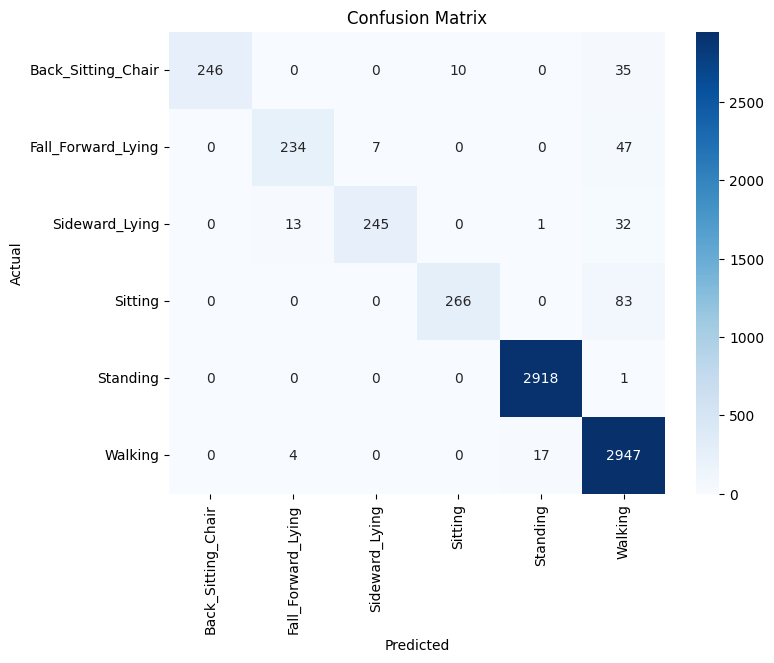

In [28]:
# Confusion Matrix

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### **Graphical Representation**

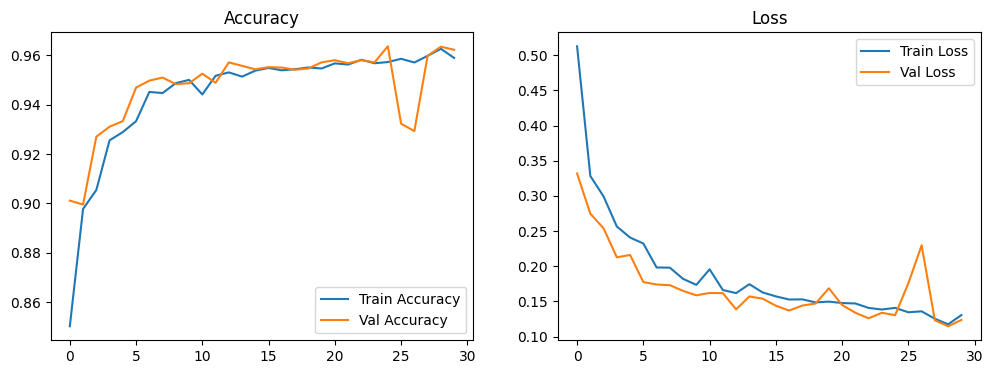

In [29]:
# Plot Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()
